In [1]:
%reset -f
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from wavhandler import *
from utils import *
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

df_mosquitos = pd.read_pickle('../data/mosquitos.pkl')

Using TensorFlow backend.


In [2]:
sz = 10000
df_an = make_df_parallel(df_mosquitos, setting='psd', insect_class='Anopheles', sample_size=sz).T
df_an['label'] = 'an'
df_ae = make_df_parallel(df_mosquitos, setting='psd',insect_class='Aedes', sample_size=sz).T
df_ae['label'] = 'ae'
df_cu = make_df_parallel(df_mosquitos, setting='psd',insect_class='Culex', sample_size=sz).T
df_cu['label'] = 'cu'

In [3]:
df_concat = pd.concat([df_ae, df_an, df_cu], axis=0, sort=False)
print(df_concat.shape)
df_concat.dropna(how='all', axis=1, inplace=True)
df_concat.dropna(how='any', axis=0, inplace=True)
print(df_concat.shape)
df_concat.head()
labelarray = df_concat.label.values
df_concat.drop('label', axis=1, inplace=True)
print(labelarray.shape)

(30000, 130)
(30000, 130)
(30000,)


In [4]:
X = df_concat.iloc[:,:-1].values
X_std = StandardScaler(with_std=True).fit_transform(X);  # standardization of data

X, y = shuffle(X, labelarray, random_state=3)
#del df

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [5]:
input_dim = x_train.shape[1]
encoding_dim = 2  
input_img = Input(shape=(input_dim,))
x = Dense(64, activation='relu')(input_img)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
encoded = Dense(encoding_dim, activation='relu')(x)
x = Dense(16, activation='relu')(encoded)
x = Dense(32, activation='relu')(encoded)
x = Dense(64, activation='relu')(x)
decoded = Dense(input_dim, activation='relu')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_6 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
__________

In [6]:
# from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape
# from keras.models import Model
# from keras import backend as K

# input_img = Input(shape=(129,1))  # adapt this if using `channels_first` image data format

# x = Conv1D(64, 3, activation='relu', padding='valid')(input_img)
# x = MaxPooling1D((2), padding='valid')(x)
# x = Conv1D(32, (3), activation='relu', padding='valid')(x)
# x = MaxPooling1D((2), padding='valid')(x)
# x = Conv1D(8, (3), activation='relu', padding='valid')(x)
# xs = MaxPooling1D((2), padding='valid')(x)
# x = Flatten()(xs)
# encoded = Dense(8, activation='relu')(x)

# x = Conv1D(8, (3), activation='relu', padding='valid')(xs)
# x = UpSampling1D((2))(x)
# x = Conv1D(32, (3), activation='relu', padding='valid')(x)
# x = UpSampling1D((2))(x)
# x = Conv1D(64, (3), activation='relu')(x)
# x = UpSampling1D((2))(x)
# x = Flatten()(x)
# decoded = Dense(129, activation='relu')(x)
# decoded = Reshape((129,1))(decoded)
# #decoded = Conv1D(129, (3), activation='sigmoid', padding='valid')(x)

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# autoencoder.summary()

In [7]:
history = autoencoder.fit(x_train, x_train,
                epochs=300,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                verbose = 1)

Train on 19200 samples, validate on 4800 samples
Epoch 1/300
19200/19200 [==============================] - 1s 44us/step - loss: 0.0039 - val_loss: 0.0027
Epoch 2/300
19200/19200 [==============================] - 1s 28us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 3/300
19200/19200 [==============================] - 1s 30us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/300
19200/19200 [==============================] - 1s 30us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 5/300
19200/19200 [==============================] - 1s 30us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/300
19200/19200 [==============================] - 1s 31us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/300
19200/19200 [==============================] - 1s 34us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/300
19200/19200 [==============================] - 1s 33us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/300
19200/19200 [==============================] - 1s 30us/step - loss: 0.0019 - val_loss: 0.00

In [14]:
# use our encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[5]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(x_test)
print(encoded_data.shape)

(6000, 2)


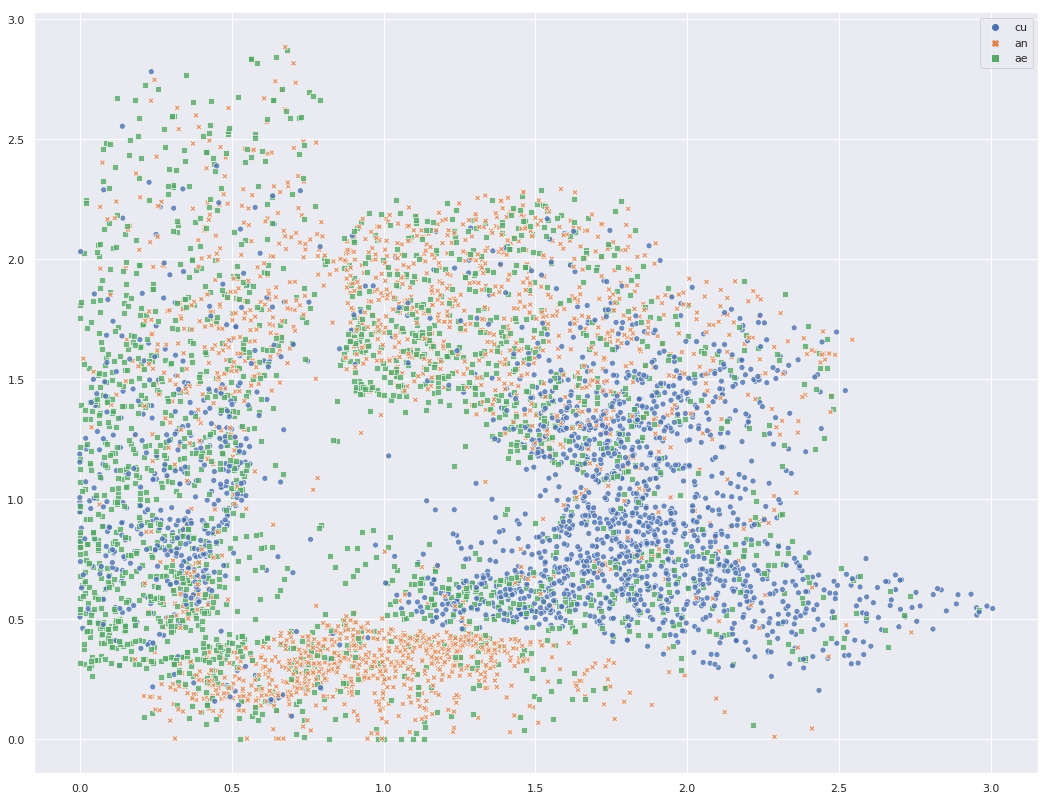

In [12]:
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(18,14))
sns.scatterplot(encoded_data[:,0], encoded_data[:,1], hue=y_test, style=y_test, alpha=0.8)

In [ ]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.plot(x_test[i])#.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(decoded_imgs[i])#.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# 0.0469 loss with bs=128 and encoding_dim=15 